In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving modeleditednew2.py to modeleditednew2.py


{'modeleditednew2.py': b'# -*- coding: utf-8 -*-\n"""ModelEditedNew2.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/13k7JZrsa9u8Kgd5WKIiYxUjn2ySaHiUT\n"""\n\nfrom keras.models import Model\nfrom keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout , Activation \nfrom keras.layers import GlobalAveragePooling2D,Dense,Reshape,AveragePooling2D,Multiply,Add\n\ndef squeeze_excite_block(inputs, ratio=8):\n    init = inputs\n    channel_axis = -1\n    filters = init.shape[channel_axis]\n    se_shape = (1, 1, filters)\n\n    se = GlobalAveragePooling2D()(init)\n    se = Reshape(se_shape)(se)\n    se = Dense(filters // ratio, activation=\'relu\', kernel_initializer=\'he_normal\', use_bias=False)(se)\n    se = Dense(filters, activation=\'sigmoid\', kernel_initializer=\'he_normal\', use_bias=False)(se)\n\n    x = Multiply()([init, se])\n    return x\n\n

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
H = 256
W = 256


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


In [ ]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x


def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x


In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.tif")))
    masks = sorted(glob(os.path.join(path, "masks", "*.tif")))
    size = int(len(images) * split)

    train_x, test_x = train_test_split(images, test_size=size, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=size, random_state=42)

    split = 0.5
    size = int(len(test_x) * split)

    valid_x, test_x = train_test_split(test_x, test_size=size, random_state=42)
    valid_y, test_y = train_test_split(test_y, test_size=size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


In [ ]:
from modeleditednew2 import build_model
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory to save files """
    create_dir("files")

    """ Hyperparaqmeters """
    batch_size = 8
    lr = 1e-4  ## 0.0001
    num_epochs = 10
    model_path = "files/model.h5"
    csv_path = "files/data.csv"

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Project/Database1"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
    train_x, train_y = shuffle(train_x, train_y)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    train_steps = (len(train_x) // batch_size)
    valid_steps = (len(valid_x) // batch_size)

    if len(train_x) % batch_size != 0:
        train_steps += 1

    if len(valid_x) % batch_size != 0:
        valid_steps += 1


Skip1 [<KerasTensor: shape=(None, 128, 128, 8) dtype=float32 (created by layer 'max_pooling2d')>, <KerasTensor: shape=(None, 64, 64, 16) dtype=float32 (created by layer 'max_pooling2d_1')>, <KerasTensor: shape=(None, 32, 32, 32) dtype=float32 (created by layer 'max_pooling2d_2')>, <KerasTensor: shape=(None, 16, 16, 64) dtype=float32 (created by layer 'max_pooling2d_3')>, <KerasTensor: shape=(None, 8, 8, 128) dtype=float32 (created by layer 'max_pooling2d_4')>]
Multiply KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='tf.math.multiply/Mul:0', description="created by layer 'tf.math.multiply'")
Skip2 [<KerasTensor: shape=(None, 128, 128, 8) dtype=float32 (created by layer 'multiply_5')>, <KerasTensor: shape=(None, 64, 64, 16) dtype=float32 (created by layer 'multiply_6')>, <KerasTensor: shape=(None, 32, 32, 32) dtype=float32 (created by layer 'multiply_7')>, <KerasTensor: shape=(None, 16, 16, 64) dtype=float32 (created by layer 'multiply_8')>

In [ ]:
from keras import backend as K

def iou_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)  

In [ ]:
from keras.losses import binary_crossentropy
import keras.backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. -score

In [ ]:
""" Model """
model = build_model((H, W, 3))
#metrics = [dice_coef, iou, Recall(), Precision()]
#model.compile(loss=[iou_loss], optimizer=Adam(lr), metrics=[iou_coef])
model.compile(optimizer = 'RMSprop', loss = [iou_coef_loss], metrics = [iou_coef])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    shuffle = False
    #callbacks=callbacks
)

history = model.history.history

Skip1 [<KerasTensor: shape=(None, 128, 128, 8) dtype=float32 (created by layer 'max_pooling2d_12')>, <KerasTensor: shape=(None, 64, 64, 16) dtype=float32 (created by layer 'max_pooling2d_13')>, <KerasTensor: shape=(None, 32, 32, 32) dtype=float32 (created by layer 'max_pooling2d_14')>, <KerasTensor: shape=(None, 16, 16, 64) dtype=float32 (created by layer 'max_pooling2d_15')>, <KerasTensor: shape=(None, 8, 8, 128) dtype=float32 (created by layer 'max_pooling2d_16')>]
Multiply KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='tf.math.multiply_2/Mul:0', description="created by layer 'tf.math.multiply_2'")
Skip2 [<KerasTensor: shape=(None, 128, 128, 8) dtype=float32 (created by layer 'multiply_21')>, <KerasTensor: shape=(None, 64, 64, 16) dtype=float32 (created by layer 'multiply_22')>, <KerasTensor: shape=(None, 32, 32, 32) dtype=float32 (created by layer 'multiply_23')>, <KerasTensor: shape=(None, 16, 16, 64) dtype=float32 (created by layer 

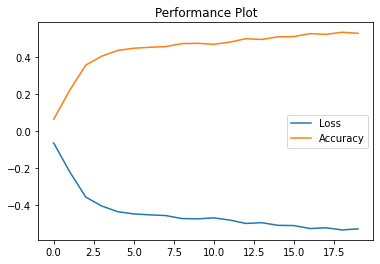

In [ ]:
# Plotting the accuracy
import matplotlib.pyplot as plt

train_loss = history['loss']
train_acc = history['iou_coef']

# Performance graph
plt.figure()
plt.plot(train_loss, label='Loss')
plt.plot(train_acc, label='Accuracy')
plt.title('Performance Plot')
plt.legend()
plt.show()


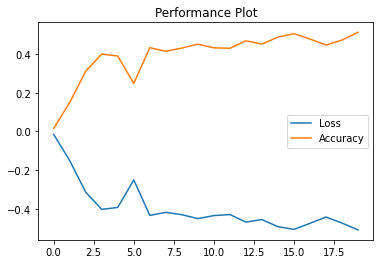

In [ ]:
val_loss = history['val_loss']
val_acc = history['val_iou_coef']

# Performance graph
plt.figure()
plt.plot(val_loss, label='Loss')
plt.plot(val_acc, label='Accuracy')
plt.title('Performance Plot')
plt.legend()
plt.show()

In [ ]:
print("Evaluate on test data")
acc = model.evaluate(valid_dataset)[1] * 100
print('validation Accuracy is:', acc, '%')


Evaluate on test data
25/25 [==============================] - 4s 159ms/step - loss: -0.5100 - iou_coef: 0.5134
validation Accuracy is: 51.33513808250427 %


In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

print("Evaluate on test data")
results = model.evaluate(test_dataset)[1]*100
print("test loss, test acc:", results)

Evaluate on test data
25/25 [==============================] - 79s 3s/step - loss: -0.4748 - iou_coef: 0.4774
test loss, test acc: 47.74136245250702
